<a href="https://colab.research.google.com/github/dkarakost/MBE_project/blob/main/Fruitdetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

if torch.__version__ != '2.5.1+cu124':
    !pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 -U --quiet
    print("PyTorch version updated to 2.5.1.")
else:
    print("PyTorch is already at the correct version (2.5.1).")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.2 MB/s eta 0:00:00
PyTorch version updated to 2.5.1.


In [ ]:
!pip install d2l==1.0.3 --quiet
!pip install scipy --quiet
!pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 698.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torchvision
from torchvision.transforms import ToPILImage
from torch import nn
from torch.nn import functional as F
from PIL import ImageFile, Image
import matplotlib.pyplot as plt
#from object_detection_utils import ResizeWithBBox, plot_bbox, plot_grid, box_xyxy_to_cxcywh, box_xywh_to_xyxy
import random
import cv2
import torchvision.models as models
import json
import random
import os
import numpy as np
#from object_detection_utils import FileBasedAPCalculator
from object_detection_utils import *

# Download the dataset
First, let's download the dataset. It consists of images of plant, bounding box annotations, and leaf counts annotations.

In [ ]:
!git clone https://git.wur.nl/abe-datasets/education/fruit-detection-challenge.git

Cloning into 'fruit-detection-challenge'...
remote: Enumerating objects: 2010, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2010 (delta 2), reused 0 (delta 0), pack-reused 2004 (from 1)
Receiving objects: 100% (2010/2010), 255.89 MiB | 17.71 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (1958/1958), done.


## The COCO dataset format

The labels for this detection dataset are stored using the COCO JSON format. COCO JSON is a data format used for object detection, segmentation, and keypoint annotation in images. It includes metadata like image paths, annotations, categories, and licenses, typically structured into keys such as "images," "annotations," "categories," and more.

Example structure:
```json
{
  "images": [
    {
      "id": 1,
      "width": 640,
      "height": 480,
      "file_name": "image1.jpg",
      "license": 1,
      "date_captured": "2023-10-01"
    }
  ],
  "annotations": [
    {
      "id": 1,
      "image_id": 1,
      "category_id": 1,
      "bbox": [50, 70, 80, 60],
      "area": 4800,
      "segmentation": [[121.39,215.89,...]],
      "iscrowd": 0
    }
  ],
  "categories": [
    {
      "id": 1,
      "name": "cat",
      "supercategory": "animal"
    },
    {
      "id": 2,
      "name": "dog",
      "supercategory": "animal"
    }
  ]
}
```

In [ ]:

# TODO: add needed imports

class FruitDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, json_path, img_folder, img_size, transforms=None):
        """
        Constructor of the FruitDetectionDataset
        :param json_path: Path to the COCO JSON file
        :param img_folder: Folder containing the images
        :param img_size: Size to resize the images
        :param transforms: List of transformations to be applied to the data
        """
        self.img_folder = img_folder
        self.transforms = transforms
        self.resize = ResizeWithBBox(img_size)

        with open(json_path, 'r') as f:
            coco_data = json.load(f)

        # TODO: Extract image info and annotations
        self.images = coco_data['images']
        self.annotations = coco_data['annotations']
        self.categories = coco_data['categories']

        # Mapping from category ID to category index
        # This creates a zero-based index
        self.category_id_to_index = {category['id']: idx for idx, category in enumerate(self.categories)}

        # Mapping from image ID to annotations
        self.img_id_to_annotations = {}
        for annotation in self.annotations:
            img_id = annotation['image_id']
            if img_id not in self.img_id_to_annotations:
                self.img_id_to_annotations[img_id] = []
            self.img_id_to_annotations[img_id].append(annotation)

        # Create a list of image paths
        self.img_files = [os.path.join(img_folder, img['file_name']) for img in self.images]

    def __getitem__(self, idx):
        # TODO Get image path and annotations
        img_info = self.images[idx]
        img_filename = img_info['file_name']
        img_id = img_info['id']
        img_path = os.path.join(self.img_folder, img_filename)
        # Get annotations for the image
        annotations = self.img_id_to_annotations.get(img_id, [])

        # Load image
        img = Image.open(img_path).convert("RGB")  # TODO PIL Image format

        # Extract bounding boxes and labels
        bboxes = []
        labels = []
        for annotation in annotations:
            x, y, width, height = annotation['bbox']
            bboxes.append([x, y, width, height])
            category_id = annotation['category_id']
            labels.append(self.category_id_to_index[category_id])


        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        if len(bboxes.shape) == 1:
            bboxes = bboxes.unsqueeze(0)

        # TODO: Resize image and boxes

        image, bboxes = self.resize(image=img, boxes=bboxes)

        #convert bbox to tensor type
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        # TODO: Convert boxes to center x, center y, width, height format
        cxcywh_boxes = []
        for box in bboxes:
          x, y, w, h = box
          center_x = x + w / 2.0
          center_y = y + h / 2.0

          cxcywh_boxes.append([center_x, center_y, w, h])
        bboxes = torch.tensor(cxcywh_boxes, dtype=torch.float32)


        # Apply other transforms
        if self.transforms:
            img = self.transforms(img)


        # TODO Add illegal boxes if needed
        illegal_needed = 3 - len(bboxes)

        illegal_labels = torch.ones((illegal_needed,), dtype=torch.int64) * -1

        illegal_boxes = torch.zeros((illegal_needed, 4), dtype=torch.float32)
        return img, {
            "labels": torch.cat((labels, illegal_labels)),
            "boxes": torch.cat((bboxes, illegal_boxes), axis=0),
        }

    def __len__(self): # TODO
        return len(self.images)


dataset test

In [ ]:
json_path="fruit-detection-challenge/detection/annotations/train.json"
train_folder="fruit-detection-challenge/detection/train/"

image_size=256
batch_size=32


training_set=FruitDetectionDataset(json_path,train_folder,image_size)
training_set[0]

TypeError: 'int' object is not subscriptable

In [ ]:

data_dir = "fruit-detection-challenge/classification"

train_imgs = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train'))
val_imgs = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'val'))

In [ ]:
train_imgs.classes

['apple', 'banana', 'orange', 'pear']

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

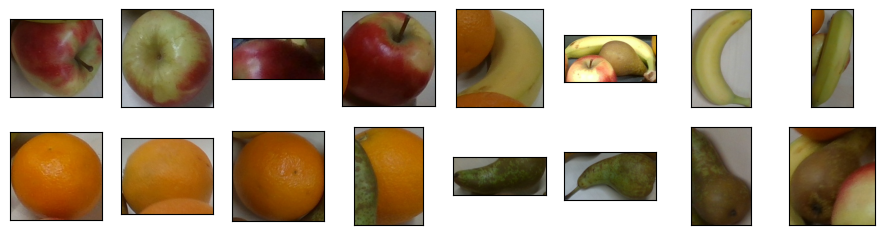

In [ ]:


class_names = train_imgs.classes
images = []

for i in range(len(train_imgs.classes)):
    class_idx = i % len(class_names)
    class_name = class_names[class_idx]
    class_images = [img for img, label in train_imgs if label == class_idx]
    for i in range(4): # Select 4 random images from the class
        images.append(random.choice(class_images))

d2l.show_images(images, 2, 8, scale=1.4)


Detecter

In [ ]:


class PredictionHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(PredictionHead, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(in_channels // 2, in_channels // 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(in_channels // 4, in_channels // 4, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels // 4),
            nn.LeakyReLU(negative_slope=0.1),
        )

        self.box_predictor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels // 4, out_channels=in_channels // 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(in_channels=in_channels // 4, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=in_channels // 4, out_channels=in_channels // 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(in_channels=in_channels // 4, out_channels=num_classes, kernel_size=3, stride=1, padding=1),
        )

        # Objectness score predictor
        self.objectness_predictor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels // 4, out_channels=in_channels // 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(in_channels=in_channels // 4, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        cls_logits = self.classifier(x)
        bbox_pred = self.box_predictor(x)
        objectness_pred = self.objectness_predictor(x)

        # Add relative grid position to the cx and cy predictions of each box
        grid_size = x.shape[-1]
        grid_y, grid_x = torch.meshgrid(
            torch.arange(grid_size, device=x.device), torch.arange(grid_size, device=x.device), indexing="ij"
        )
        cx = bbox_pred[:, 0, :, :]
        cy = bbox_pred[:, 1, :, :]
        w = bbox_pred[:, 2, :, :]
        h = bbox_pred[:, 3, :, :]
        cx = (cx + (grid_x)) / grid_size
        cy = (cy + (grid_y)) / grid_size
        bbox_pred = torch.stack([cx, cy, w, h], dim=1)

        return cls_logits, bbox_pred, objectness_pred


class ObjectDetector(nn.Module):
    def __init__(self, n_classes, pretrained=True):
        super(ObjectDetector, self).__init__()

        # We add the background class
        self.n_classes = n_classes

        # Backbone
        backbone = models.resnet18(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(backbone.children())[:-3])

        # Layer 1
        self.block_1 = nn.Sequential(*list(backbone.children())[-3])

        self.prediction_head = PredictionHead(512, self.n_classes)

    def forward(self, x):
        features = self.backbone(x)
        y_ = self.block_1(features)

        cls_logits, bbox_pred, objectness_pred = self.prediction_head(y_)
        cls_preds = cls_logits.flatten(2, 3).permute(0, 2, 1)
        box_preds = bbox_pred.flatten(2, 3).permute(0, 2, 1)
        obj_preds = objectness_pred.flatten(2, 3).permute(0, 2, 1)

        return {"pred_logits": cls_preds, "pred_boxes": box_preds, "pred_objectness": obj_preds}

add noise to validation set

In [ ]:
def add_noise_to_box(box_coords, noise_factor=0.1):
    noisy_box = []
    for coord in box_coords:
        noisy_coord = np.random.normal(loc=coord, scale=noise_factor * coord)
        noisy_box.append(max(0, min(noisy_coord, 1)))  # Ensure the values are within [0, 1]
    return noisy_box

def remove_random_predictions(predictions, removal_fraction=0.2):
    num_predictions = len(predictions)
    indices_to_remove = np.random.choice(num_predictions, size=int(removal_fraction * num_predictions), replace=False)
    remaining_predictions = [pred for i, pred in enumerate(predictions) if i not in indices_to_remove]
    return remaining_predictions

def process_predictions(file_path):
    predictions = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            image_name = parts[0]
            box_coords = list(map(float, parts[1:5]))
            class_id = int(parts[5])
            confidence = 1.0
            predictions.append((image_name, *box_coords, class_id, confidence))

    noisy_predictions = []
    for pred in predictions:
        image_name, x_center, y_center, width, height, class_id, conf = pred
        noisy_box = add_noise_to_box([x_center, y_center, width, height], 0.05)
        noisy_predictions.append((image_name, *noisy_box, class_id, conf))

    remaining_predictions = remove_random_predictions(noisy_predictions, 0.1)

    return remaining_predictions

def save_processed_predictions(predictions, output_file_path):
    with open(output_file_path, 'w') as f:
        for pred in predictions:
            line = ','.join(map(str, pred))
            f.write(line + '\n')


In [ ]:

val_gt = "fruit-detection-challenge/detection/annotations/val.txt"

noisy_val_gt = 'processed_predictions.txt'

predictions = process_predictions(val_gt)
save_processed_predictions(predictions, noisy_val_gt)


ap_calculator = FileBasedAPCalculator(
    val_gt,
    noisy_val_gt,
)
ap = ap_calculator.calculate_map()

Build training set and validation set

In [ ]:
json_path="fruit-detection-challenge/detection/annotations/train.json"
train_folder="fruit-detection-challenge/detection/train/"

image_size=256
batch_size=32


training_set=FruitDetectionDataset(json_path,train_folder,image_size)

train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader=torch.utils.data.DataLoader(noisy_val_gt, batch_size=batch_size, shuffle=True, num_workers=2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


total num of parameters in the model: 13119430


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-3-19e8d0e18aa6>", line 62, in __getitem__
    if len(bboxes.shape) == 1:
           ^^^^^^^^^^^^
AttributeError: 'list' object has no attribute 'shape'


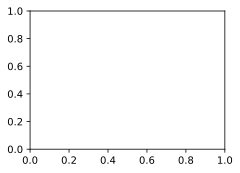

In [ ]:

def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3, weight_decay=1e-4, step_size=20, gamma=0.1):
    device = d2l.try_gpu()
    model = model.to(device)
    matcher = HungarianMatcher()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    print("total num of parameters in the model:", sum(p.numel() for p in model.parameters()))

    timer = d2l.Timer()
    animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs], legend=["class error", "L1 error", "val AP"])

    ap_calculator = APCalculator(val_loader)

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        model.train()
        for img, targets in train_loader:
            timer.start()

            img = img.to(device)

            # Remove illegal targets
            new_targets = []
            for i in range(targets["labels"].shape[0]):
                labels = targets["labels"][i]
                boxes = targets["boxes"][i]
                new_targets.append({"labels": labels[labels != -1].to(device), "boxes": boxes[labels != -1].to(device)})

            outputs = model(img)

            num_boxes = sum(len(t["labels"]) for t in new_targets)
            num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)

            src_logits = outputs["pred_logits"]
            src_boxes = outputs["pred_boxes"]
            src_objectness = outputs["pred_objectness"]

            indices = matcher(outputs, new_targets)  # Run matcher
            idx = get_src_permutation_idx(indices)

            # Loss class
            target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(new_targets, indices)])
            target_classes = torch.full(src_logits.shape[:2], -100, dtype=torch.int64, device=device)
            target_classes[idx] = target_classes_o
            loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, ignore_index=-100)

            # Loss boxes L1 and GIOU
            src_boxes = src_boxes[idx]
            target_boxes = torch.cat([t["boxes"][i] for t, (_, i) in zip(new_targets, indices)], dim=0)

            loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction="none")
            loss_bbox = loss_bbox.sum() / num_boxes

            # Loss objectness
            target_objectness = torch.zeros_like(src_objectness, device=device)
            target_objectness[idx] = 1
            loss_objectness = F.mse_loss(src_objectness, target_objectness, reduction="mean")

            # Sum the losses
            loss = loss_ce + loss_bbox + loss_objectness

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            metric.add(
                loss_ce.cpu().detach().numpy(),
                loss_bbox.cpu().detach().numpy(),
                loss_objectness.cpu().detach().numpy(),
                img.size()[0],
            )
        scheduler.step()
        cls_err, L1_error, obj_error = metric[0] / metric[3], metric[1] / metric[3], metric[2] / metric[3]
        ap = ap_calculator.calculate_map(model, nms_threshold=0.5)
        print(ap)
        animator.add(epoch + 1, (cls_err, L1_error, ap["map_50"]))
    print(f"{len(train_loader.dataset) / timer.stop():.1f} examples/sec on {str(device)}")


model = ObjectDetector(n_classes=1)
train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3, weight_decay=1e-4, step_size=15, gamma=0.1)